In [1]:
import zipfile

! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-09-23 08:34:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.7MB/s    in 8.5s    

2023-09-23 08:34:28 (19.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/train"):
  class_names=dirnames
  break

class_names

['steak',
 'sushi',
 'ice_cream',
 'ramen',
 'grilled_salmon',
 'pizza',
 'fried_rice',
 'chicken_curry',
 'hamburger',
 'chicken_wings']

In [5]:
train_dir="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_data=train_datagen.flow_from_directory(train_dir,
                                             batch_size=32,
                                             target_size=(244,244),
                                             class_mode="categorical")

test_data=test_datagen.flow_from_directory(test_dir,
                                             batch_size=32,
                                             target_size=(244,244),
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# setting up callback (tensorboard)

In [7]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files to : {log_dir}")
  return tensorboard_callback

# creating models using tensorflow hub

In [8]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
def create_model(model_url,num_classes=10):

  feature_extraction_layer=hub.KerasLayer(model_url,
                                          trainable=False,
                                          input_shape=(244,244,3),
                                          name="feature_extraction_layer")

  model=tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model

# creating a resnet model

In [12]:
resnet_model=create_model(resnet_url,10)

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics="accuracy")

In [ ]:
resnet_model.summary()

In [14]:
resnet_history=resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="resnet50v2")])

saving tensorboard log files to : tensorflow_hub/resnet50v2/20230923-094746
Epoch 1/5
24/24 [==============================] - 28s 617ms/step - loss: 1.8602 - accuracy: 0.4200 - val_loss: 1.1998 - val_accuracy: 0.6292
Epoch 2/5
24/24 [==============================] - 12s 519ms/step - loss: 0.9415 - accuracy: 0.7133 - val_loss: 0.8269 - val_accuracy: 0.7544
Epoch 3/5
24/24 [==============================] - 13s 561ms/step - loss: 0.6564 - accuracy: 0.8173 - val_loss: 0.7047 - val_accuracy: 0.7964
Epoch 4/5
24/24 [==============================] - 12s 525ms/step - loss: 0.5102 - accuracy: 0.8800 - val_loss: 0.6583 - val_accuracy: 0.8004
Epoch 5/5
24/24 [==============================] - 12s 503ms/step - loss: 0.4114 - accuracy: 0.9120 - val_loss: 0.6262 - val_accuracy: 0.8060


# plotting loss and accuracy

In [15]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["accuracy"]))

  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss,label="validation loss")
  plt.xlabel("epochs")
  plt.title("loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="training accuracy")
  plt.plot(epochs,val_accuracy,label="validation accuracy")
  plt.xlabel("epochs")
  plt.title("accuracy")
  plt.legend()


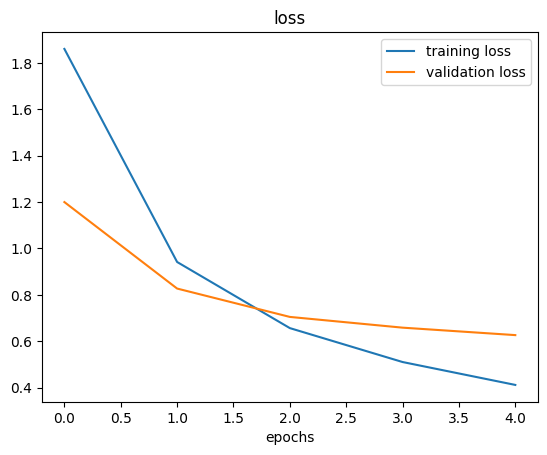

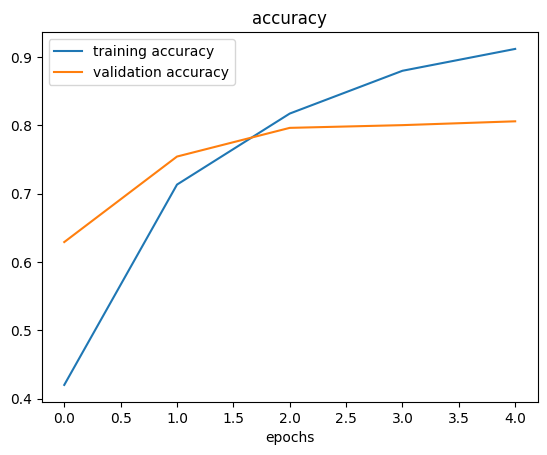

In [16]:
plot_loss_curves(resnet_history)

# creating a efficientnet model

In [18]:
efficientnet_model=create_model(efficientnet_url,10)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics="accuracy")

efficientnet_history=efficientnet_model.fit(train_data,
                                            epochs=5,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetb0")]
                                            )

saving tensorboard log files to : tensorflow_hub/efficientnetb0/20230923-100840
Epoch 1/5
24/24 [==============================] - 24s 578ms/step - loss: 1.8543 - accuracy: 0.4373 - val_loss: 1.3152 - val_accuracy: 0.7264
Epoch 2/5
24/24 [==============================] - 11s 472ms/step - loss: 1.0901 - accuracy: 0.7707 - val_loss: 0.8750 - val_accuracy: 0.8132
Epoch 3/5
24/24 [==============================] - 11s 462ms/step - loss: 0.7722 - accuracy: 0.8360 - val_loss: 0.7041 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 12s 522ms/step - loss: 0.6244 - accuracy: 0.8693 - val_loss: 0.6142 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 11s 450ms/step - loss: 0.5245 - accuracy: 0.8920 - val_loss: 0.5613 - val_accuracy: 0.8592


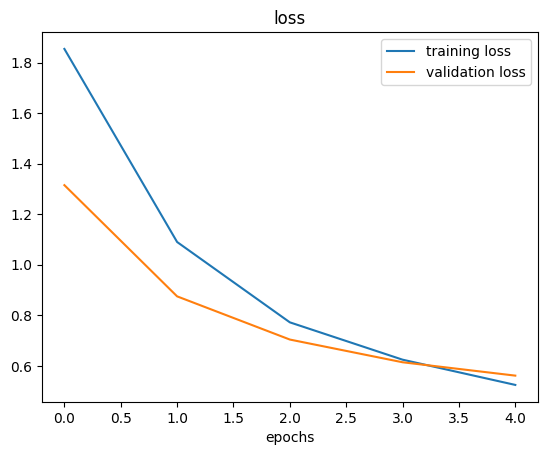

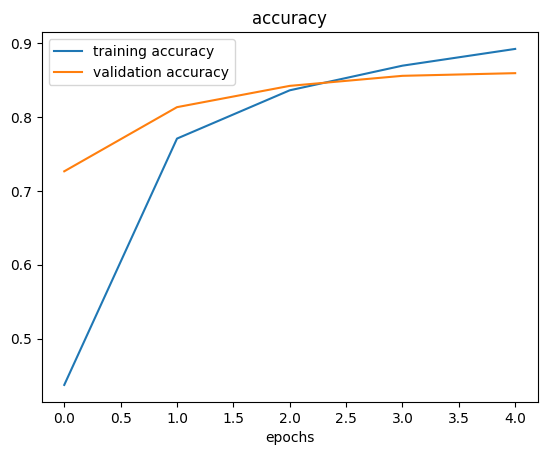

In [19]:
plot_loss_curves(efficientnet_history)